<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Precipitation_cross_correlation_exploration_square_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upstream Precipitation Cross Correlation Exploration

**Author:** Ravi Kohli

**College:** Christ Church

**Date:** January 8th, 2021

**Goal:**
- To calculate the temporal cross-correlation between the precipitation data upstream and the daily Sandford generation and find the optimal time lag
- This notebook will be for grid-square 2

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the modules
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## Import the Data

### Sandford Daily Generation Data

In [ ]:
# unpickle the processed daily generation dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'daily_sandford_generation_data'
infile = open(path+filename, 'rb')
sandford_daily_df = pickle.load(infile)
infile.close()

In [ ]:
sandford_daily_df.tail(30)

,Reading Date,Incremental Reading,Meter Reading
339,2018-11-16,0.000,548473.50
340,2018-11-15,87.654,548473.50
341,2018-11-14,169.011,548385.84
342,2018-11-13,27.085,548216.83
343,2018-11-12,0.000,548189.75
344,2018-11-11,0.000,548189.75
345,2018-11-10,8.090,548189.75
346,2018-11-09,31.744,548181.66
347,2018-11-08,0.000,548149.91
348,2018-11-07,0.000,548149.91


In [ ]:
sandford_daily_df[sandford_daily_df['Incremental Reading'] <= 0]

,Reading Date,Incremental Reading,Meter Reading
32,2019-09-20,0.0,1648133.02
33,2019-09-19,0.0,1648133.02
34,2019-09-18,0.0,1648133.02
35,2019-09-17,0.0,1648133.02
36,2019-09-16,0.0,1648133.02
...,...,...,...
364,2018-10-22,0.0,548149.91
365,2018-10-21,0.0,548149.91
366,2018-10-20,0.0,548149.91
367,2018-10-19,0.0,548149.91


### Upstream Precipitation Data

In [ ]:
# unpickle the processed daily precipitation dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_upstream2_met_daily'
infile = open(path+filename, 'rb')
upstream_precip_daily_df = pickle.load(infile)
infile.close()

In [ ]:
# unpickle the processed daily precipitation dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_precipitation_data_processed'
infile = open(path+filename, 'rb')
upstream_precip_daily_df = pickle.load(infile)
infile.close()

In [ ]:
upstream_precip_daily_df

,Date,Rainfall mm 1 dpl no traces,Rain day (0.2 mm or more),Wet day (1.0 mm or more)
0,1815-01-01,NaN,NaN,NaN
1,1815-01-02,NaN,NaN,NaN
2,1815-01-03,NaN,NaN,NaN
3,1815-01-04,NaN,NaN,NaN
4,1815-01-05,NaN,NaN,NaN
...,...,...,...,...
74901,2020-01-27,2.8,1.0,1.0
74902,2020-01-28,0.0,0.0,0.0
74903,2020-01-29,0.0,0.0,0.0
74904,2020-01-30,0.0,0.0,0.0


In [ ]:
# define a mask to extract the rows from upstream precip_daily_df which have the same date as the generation data
# format of mask: YYYY-MM-DD
upstream_mask_start = pd.to_datetime(min(sandford_daily_df['Reading Date']))
upstream_mask_end = pd.to_datetime(max(sandford_daily_df['Reading Date']))

In [ ]:
upstream_mask = (upstream_precip_daily_df['Date'] >= upstream_mask_start) & (upstream_precip_daily_df['Date'] <= upstream_mask_end)

# extract the rows from the dataframe by using the mask
upstream_extracted_df = upstream_precip_daily_df.loc[upstream_mask]

In [ ]:
upstream_extracted_df

,Date,Rainfall mm 1 dpl no traces,Rain day (0.2 mm or more),Wet day (1.0 mm or more)
74435,2018-10-18,0.0,0.0,0.0
74436,2018-10-19,0.0,0.0,0.0
74437,2018-10-20,0.0,0.0,0.0
74438,2018-10-21,0.0,0.0,0.0
74439,2018-10-22,0.0,0.0,0.0
...,...,...,...,...
74800,2019-10-18,0.2,1.0,0.0
74801,2019-10-19,0.0,0.0,0.0
74802,2019-10-20,0.0,0.0,0.0
74803,2019-10-21,0.0,0.0,0.0


we notice that `upstream_extracted_df` is shorter than `sandford_daily_df`, so we need to remove those dates not in the precipitation data

In [ ]:
len(upstream_extracted_df['Date']), len(sandford_daily_df['Reading Date'])

(370, 369)

In [ ]:
dates_to_remove = (set(sandford_daily_df['Reading Date']) - set(upstream_extracted_df['Date']))
dates_to_remove

set()

In [ ]:
# iterating through the list of dates and removing them
sandford_daily_reduced = sandford_daily_df
for i in dates_to_remove:
  sandford_daily_reduced = sandford_daily_reduced[sandford_daily_reduced['Reading Date'] != i]

In [ ]:
# there is a date in the precipitation data that isn't in the generation data and therefore needs to be removed
dates_to_remove_pt2 = set(upstream_extracted_df['Date']) - set(sandford_daily_reduced['Reading Date'])
dates_to_remove_pt2

{Timestamp('2019-06-01 00:00:00')}

In [ ]:
upstream_reduced = upstream_extracted_df[upstream_extracted_df['Date'] != list(dates_to_remove_pt2)[0]]

We now have two dataframes of length 362:
- `upstream_reduced`
- `sandford_daily_reduced`

In [ ]:
upstream_reduced.reset_index(drop=True)

,Date,Rainfall mm 1 dpl no traces,Rain day (0.2 mm or more),Wet day (1.0 mm or more)
0,2018-10-18,0.0,0.0,0.0
1,2018-10-19,0.0,0.0,0.0
2,2018-10-20,0.0,0.0,0.0
3,2018-10-21,0.0,0.0,0.0
4,2018-10-22,0.0,0.0,0.0
...,...,...,...,...
364,2019-10-18,0.2,1.0,0.0
365,2019-10-19,0.0,0.0,0.0
366,2019-10-20,0.0,0.0,0.0
367,2019-10-21,0.0,0.0,0.0


## Temporal Cross-Correlation Analysis

This code was obtained from: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

In [ ]:
# define this function to find the temporal cross correlation
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

The code below was obtained from: https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

In [ ]:
def crosscorr2(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
# defining the datasets
d1 = sandford_daily_reduced['Incremental Reading']
d2 = upstream_reduced['Rainfall mm 1 dpl no traces']
#d2 = upstream_reduced['Precipitation']

d1_ser = pd.Series(d1.values)
d2_ser = pd.Series(d2.values)

In [ ]:
start_lag = -25                                                                 # define one end of the lag range
end_lag = 25 + 1                                                                # define other end of the lag range
lag_linspace = [i for i in range(start_lag, end_lag)]                           # define list of dates to plot in graph
xcov_daily = [crosscorr2(d1_ser, d2_ser, lag=i) for i in range(start_lag, end_lag)]   # calculate cross-correlations as a function of lag

In [ ]:
#xcov_daily

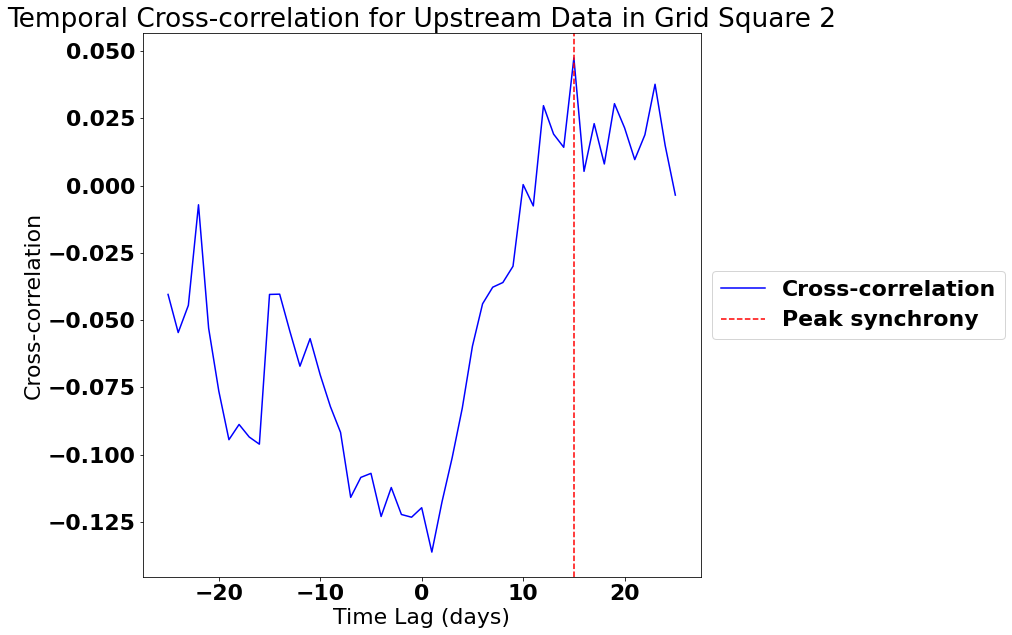

In [ ]:
# Let us plot the cross-correlation profile
corr_fig, corr_ax = plt.subplots(figsize = (10, 10))
corr_ax.plot(lag_linspace, xcov_daily, 'b', label = 'Cross-correlation')  
corr_ax.axvline(lag_linspace[np.argmax(xcov_daily)], color='r', linestyle='--', label = 'Peak synchrony')           # Putting a line for peak synchrony
corr_ax.set(title = 'Temporal Cross-correlation for Upstream Data in Grid Square 2', xlabel= 'Time Lag (days)', ylabel='Cross-correlation')
corr_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [ ]:
seconds = 5
fps = 30

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


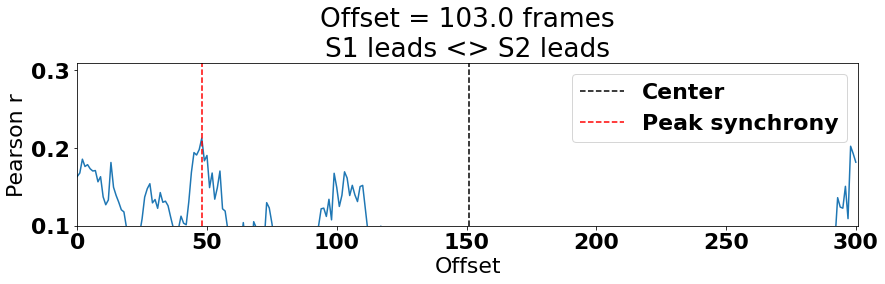

In [ ]:
rs = [crosscorr(d1_ser, d2_ser, lag) for lag in range(-int(seconds * fps), int(seconds*fps+1))]
offset = np.ceil(len(rs)/2) - np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k', linestyle = '--', label='Center')
ax.axvline(np.argmax(rs), color='r', linestyle='--', label = 'Peak synchrony')
ax.set(title = f'Offset = {offset} frames\nS1 leads <> S2 leads', ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()